# DANTE.py Figure Maker

En este documento se harán todas las gráficas para el TFG. Los datos númericos se han calculado previamente con DANTE.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize as opt
import multiprocessing as mp
from tqdm import tqdm

# Physical parameters (solar mass = 1.98847e30 kg)
G = 1.4765679173556 # G in units of km / solar masses

## Estrellas de densidad constante

### Comparación con el modelo teórico

3.2945634030407462
3.3218333168976093
3.3005158945486923


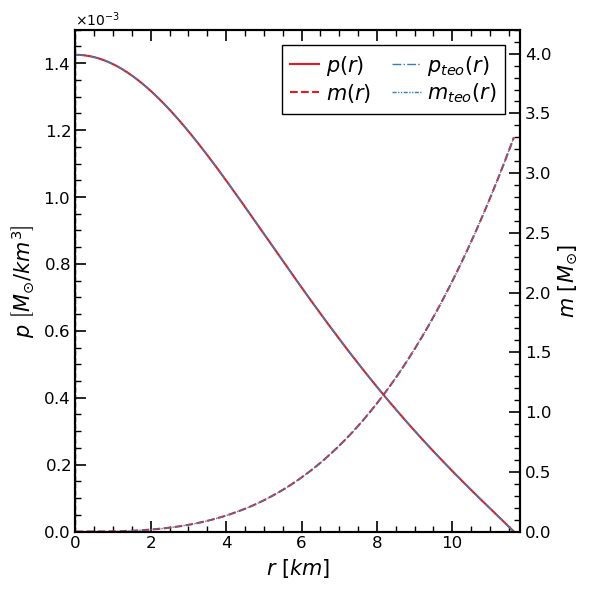

In [3]:
###############################################################################
# Define the functions
###############################################################################
def eos (p, eos_type, rho_0=5e-4, k=10, gamma=2):
    """
    Given a pressure p, gives the value of density rho in acordance to the EoS.
    The function accepts 2 types of EoS: const = Constant density, poly = Polytropic EoS.

    Parameters
    ----------
    p : float
        Pressure.
    eos_type : int
        Type of EoS to use. 0 for an EoS of constant density. 1 for a Polytropic EoS
    rho_0 : float, optional
        Value of denisty in the case of eos_type = 'const'. The default is 2e-4.
    k : float, optional
        If eos_type='poly', value of the polytropic constant. The default is 10.
    gamma : TYPE, optional
        If eos_type='poly', value of the polytropic index. The default is 2.
    Returns
    -------
    TYPE
        Density(p).

    """
    if p <= 0:
        return 0
    
    if eos_type == 0:
        rho = rho_0
    elif eos_type == 1:
        rho = rho = (p / k) ** (1/gamma)
        
    return rho

def system_of_ODE (r, y, eos_type):
    """
    Function that calculates the derivatives of m and the pressure. This function is used for the runge-Kutta method.

    Parameters
    ----------
    r : float
        radius inside of the star.
    y : tuple
        (m, p), where m is the mass, p is the preassure of the fluid, evaluated at point r..
    eos_type : int
        Type of EoS to use. 0 for an EoS of constant density. 1 for a Polytropic EoS.  
    Returns
    -------
    dm_dr : float
        rate of change of the mass.
    dp_dr : float
        rate of change of the pressure of fluid.

    """
    m, p = y
    rho = eos(p, eos_type)
    
    dm_dr = 4 * np.pi * (rho) * r**2
    dphi_dr = (G * m + 4 * np.pi * G * r**3 * (p)) / (r * (r - 2 * G * m))
    dp_dr = -(rho + p) * dphi_dr
    
    return (dm_dr, dp_dr)
    
def RK4O_with_stop (y0, r_range, h, eos_type):
    """
    Function that integrates the y vector using a Runge-Kutta 4th orther method.
    Due to the physics of our problem. The function is built with a condition that doesn't allow negative pressures. 

    Parameters
    ----------
    y0 : tuple
        Starting conditions for our variables: (m_0, p_c)
    r_range : tuple
        Range of integratio: (r_0, r_max)
    h : float
        Step size of integration.
    eos_type : int
        Type of EoS to use. 0 for an EoS of constant density. 1 for a Polytropic EoS.
    Returns
    -------
    r_values : array
        Array containing the different values of r.
        
    y_values : array
        Array containig the solutions for the vector y: (m_values, p_values).
    """
    
    r_start, r_end = r_range
    r_values = [r_start]
    y_values = [y0]
    
    r = r_start
    y = np.array(y0)

    while r <= r_end:
        k1 = h * np.array(system_of_ODE(r, y, eos_type))
        k2 = h * np.array(system_of_ODE(r + h / 2, y + k1 / 2, eos_type))
        k3 = h * np.array(system_of_ODE(r + h / 2, y + k2 / 2, eos_type))
        k4 = h * np.array(system_of_ODE(r + h, y + k3, eos_type))

        y_next = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

        # Stopping conditions: p<p_c*1e-10
        if y_next[1] <= y0[1]*1e-10: # If both pressures drop to 0 then the star stops there.
            break
        
        r += h
        r_values.append(r)
        y_values.append(y_next)
        y = y_next
        
    return (np.array(r_values), np.array(y_values))

def TOV_solver (y0, r_range, h, eos_type):
    """
    Using a 4th Runge Kutta method, it solves the TOV for a perfect fluid star.
    It guives the mass and preassure values in all of the stars radius.

    Parameters
    ----------
    y0 : tuple
        Starting conditions for our variables: (m_0, p_c).
    r_range : tuple
        Range of integratio: (r_0, r_max).
    h : float
        Step size of integration.
    eos_type : int
        Type of EoS to use. 0 for an EoS of constant density. 1 for a Polytropic EoS

    Returns
    -------
    r_values : array
        Array containing the different values of r.
    m_values : array
        Array containing the different values of m(r).
    p_values : array
        Array containing the different values of p(r).
    """
    
    r_values, y_values = RK4O_with_stop(y0, r_range, h, eos_type)
    
    m_values = y_values[:, 0]
    p_values = y_values[:, 1]
    
    return (r_values, m_values, p_values)

def find_pc (M_target, eos_type):
    """
    Finds the value of central pressure that creates a star of mass M_target.

    Parameters
    ----------
    M_target : float
        Desired mass.
    eos_type : int
        Type of EoS to use. 0 for an EoS of constant density. 1 for a Polytropic EoS.

    Raises
    ------
    ValueError
        When the root finding algorithm does not converge.

    Returns
    -------
    float
        value of pc that creates a star of mass M_target.
    """
    def f(pc):
        r, m, p = TOV_solver((0, pc), (1e-6, 100), 1e-3, eos_type)
        M = m[-1]
        print(M)
        return (M - M_target) / M_target
    
    pc_guess = M_target*1.4e-3/3.3
    result = opt.root_scalar(f, x0=pc_guess, method='secant', x1=pc_guess*1.1, xtol=1e-4)
    if result.converged:
        return result.root
    else:
        raise ValueError("Root-finding did not converge")

def theoretical_data (M):
    """
    Solves the hydrostatic equillibrium of a star of constant density and mass M ussing the theoretical equations.

    Parameters
    ----------
    M : float
        Mass of the star.

    Returns
    -------
    r_teo : array
        Array containing the theoretical values of r.
    m_teo : TYPE
        Array containing the theoretical values of m(r).
    p_teo : TYPE
        Array containing the theoretical values of p(r).
    """
    rho = 5e-4
    R = (3/4 * M/(rho*np.pi))**(1/3)
    
    r_teo = np.linspace(0, R, 500)
    m_teo = 4/3 * rho * np.pi * r_teo
    term1 = np.sqrt(R**3 - 2 * G * M * R**2)
    term2 = np.sqrt(R**3 - 2 * G * M * r_teo**2)
    numerator = term1 - term2
    denominator = term2 - 3 * term1
    p_teo = rho * (numerator / denominator)
    
    return (r_teo, m_teo, p_teo)
      
###############################################################################
# Define the parameters
###############################################################################

M = 3.3
eos_type = 0

###############################################################################
# Calculate the data
###############################################################################

pc = find_pc(M, eos_type)

r, m, p = TOV_solver((0, pc), (1e-6, 100), 1e-3, eos_type)

r_teo, m_teo, p_teo = theoretical_data(M)

###############################################################################
# Plot the data
###############################################################################

fig, ax1 = plt.subplots(figsize=(6, 6))
colors = sns.color_palette("Set1", 10)

# Plot p
ax1.plot(r, p, label=r'$p(r)$', color = colors[0], linewidth=1.5, linestyle='-')
ax1.plot(r_teo, p_teo, label=r'$p_{teo}(r)$', color = colors[1], linewidth=1, linestyle='-.')
ax1.set_xlabel(r'$r$ $\left[km\right]$', fontsize=15, loc='center')
ax1.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center', color='k')
ax1.tick_params(axis='y', colors='k')
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))

# Plot m
ax2 = ax1.twinx()
ax2.plot(r, m, label=r'$m(r)$', color = colors[0], linewidth=1.5, linestyle='--')
ax2.plot(r, m, label=r'$m_{theo}(r)$', color = colors[1], linewidth=1, linestyle=(0, (3, 1, 1, 1, 1, 1)))
ax2.set_ylabel(r'$m$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center', color='k')
ax2.tick_params(axis='y', colors='k')

# Add axis lines
ax1.axhline(0, color='k', linewidth=1.0, linestyle='--')
ax1.axvline(0, color='k', linewidth=1.0, linestyle='--')

# Configure ticks
ax1.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True)
ax1.minorticks_on()
ax2.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
ax2.minorticks_on()

# Set thicker axes
for ax in [ax1, ax2]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
# Set limits
if True == True:
    ax1.set_xlim(0, 11.8)
    ax1.set_ylim(0, 1.5e-3)
    ax2.set_ylim(0, 4.2)
    
# Configure ticks spacing
if True == True:
    ax1.set_xticks(np.arange(0, 12, 2))
    #ax1.set_xticks(np.arange(0, 9.6, 0.2), minor=True)
    ax1.set_yticks(np.arange(0, 1.51e-3, 0.2e-3))
    #ax1.set_yticks(np.arange(0, 8.1e-5, 0.2e-5), minor=True)
    ax2.set_yticks(np.arange(0, 4.21, 0.5))
    #ax2.set_yticks(np.arange(0, 1.01, 0.02), minor=True)
    
handles_list = [
    mlines.Line2D([], [], color=colors[0], linestyle='-', linewidth=1.5, label=r"$p(r)$"),
    mlines.Line2D([], [], color=colors[0], linestyle='--', linewidth=1.5, label=r"$m(r)$"),
    mlines.Line2D([], [], color=colors[1], linestyle='-.', linewidth=1, label=r"$p_{teo}(r)$"),
    mlines.Line2D([], [], color=colors[1], linestyle=(0, (3, 1, 1, 1, 1, 1)), linewidth=1, label=r"$m_{teo}(r)$"),
    ]
    
plt.legend(handles=handles_list, fontsize=15, loc = "upper right", bbox_to_anchor=(0.99, 0.99), frameon=True, fancybox=False,
           ncol = 2,edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)
    
plt.tight_layout()
plt.savefig(rf"figures\constant_compare_scaled.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Solución TOV, diferentes masas

Star of mass 3.3 solved
Star of mass 3.4 solved
Star of mass 3.5 solved
Star of mass 3.6 solved


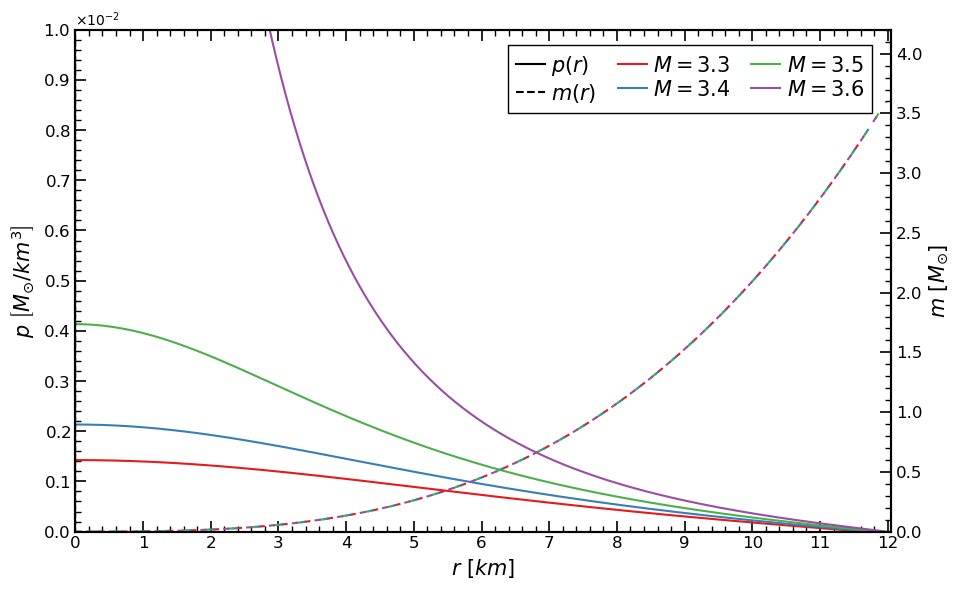

In [5]:
###############################################################################
# Define the functions
###############################################################################
def eos (p, rho_0=5e-4):
    """
    Given a pressure p, gives the value of density rho in acordance to the EoS.
    The function accepts 2 types of EoS: const = Constant density, poly = Polytropic EoS.

    Parameters
    ----------
    p : float
        Pressure.
    rho_0 : float, optional
        Value of denisty in the case of eos_type = 'const'. The default is 2e-4.

    Returns
    -------
    TYPE
        Density(p).

    """
    if p <= 0:
        return 0
    
    rho = rho_0
        
    return rho

def system_of_ODE (r, y):
    """
    Function that calculates the derivatives of m and the pressure. This function is used for the runge-Kutta method.

    Parameters
    ----------
    r : float
        radius inside of the star.
    y : tuple
        (m, p), where m is the mass, p is the preassure of the fluid, evaluated at point r. 
    
    Returns
    -------
    dm_dr : float
        rate of change of the mass.
    dp_dr : float
        rate of change of the pressure of fluid.

    """
    m, p = y
    rho = eos(p)
    
    dm_dr = 4 * np.pi * (rho) * r**2
    dphi_dr = (G * m + 4 * np.pi * G * r**3 * (p)) / (r * (r - 2 * G * m))
    dp_dr = -(rho + p) * dphi_dr
    
    return (dm_dr, dp_dr)
    
def RK4O_with_stop (y0, r_range, h):
    """
    Function that integrates the y vector using a Runge-Kutta 4th orther method.
    Due to the physics of our problem. The function is built with a condition that doesn't allow negative pressures. 

    Parameters
    ----------
    y0 : tuple
        Starting conditions for our variables: (m_0, p_c)
    r_range : tuple
        Range of integratio: (r_0, r_max)
    h : float
        Step size of integration.
        
    Returns
    -------
    r_values : array
        Array containing the different values of r.
        
    y_values : array
        Array containig the solutions for the vector y: (m_values, p_values).
    """
    
    r_start, r_end = r_range
    r_values = [r_start]
    y_values = [y0]
    
    r = r_start
    y = np.array(y0)

    while r <= r_end:
        k1 = h * np.array(system_of_ODE(r, y))
        k2 = h * np.array(system_of_ODE(r + h / 2, y + k1 / 2))
        k3 = h * np.array(system_of_ODE(r + h / 2, y + k2 / 2))
        k4 = h * np.array(system_of_ODE(r + h, y + k3))

        y_next = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

        # Stopping conditions: p<p_c*1e-10
        if y_next[1] <= y0[1]*1e-10: # If both pressures drop to 0 then the star stops there.
            break
        
        r += h
        r_values.append(r)
        y_values.append(y_next)
        y = y_next
        
    return (np.array(r_values), np.array(y_values))

def TOV_solver (y0, r_range, h):
    """
    Using a 4th Runge Kutta method, it solves the TOV for a perfect fluid star.
    It guives the mass and preassure values in all of the stars radius.

    Parameters
    ----------
    y0 : tuple
        Starting conditions for our variables: (m_0, p_c).
    r_range : tuple
        Range of integratio: (r_0, r_max).
    h : float
        Step size of integration.

    Returns
    -------
    r_values : array
        Array containing the different values of r.
    m_values : array
        Array containing the different values of m(r).
    p_values : array
        Array containing the different values of p(r).
    """
    
    r_values, y_values = RK4O_with_stop(y0, r_range, h)
    
    m_values = y_values[:, 0]
    p_values = y_values[:, 1]
    
    return (r_values, m_values, p_values)

def find_pc (M_target):
    """
    Finds the value of central pressure that creates a star of mass M_target.

    Parameters
    ----------
    M_target : float
        Desired mass.
    eos_type : int
        Type of EoS to use. 0 for an EoS of constant density. 1 for a Polytropic EoS.

    Raises
    ------
    ValueError
        When the root finding algorithm does not converge.

    Returns
    -------
    float
        value of pc that creates a star of mass M_target.
    """
    def f(pc):
        r, m, p = TOV_solver((0, pc), (1e-6, 100), 1e-3)
        M = m[-1]
        return (M - M_target) / M_target
    
    pc_guess = M_target*1.4e-3/3.3
    result = opt.root_scalar(f, x0=pc_guess, method='secant', x1=pc_guess*1.1, xtol=1e-4)
    if result.converged:
        return result.root
    else:
        raise ValueError("Root-finding did not converge")

def theoretical_data (M):
    """
    Solves the hydrostatic equillibrium of a star of constant density and mass M ussing the theoretical equations.

    Parameters
    ----------
    M : float
        Mass of the star.

    Returns
    -------
    r_teo : array
        Array containing the theoretical values of r.
    m_teo : TYPE
        Array containing the theoretical values of m(r).
    p_teo : TYPE
        Array containing the theoretical values of p(r).
    """
    rho = 5e-4
    R = (3/4 * M/(rho*np.pi))**(1/3)
    
    r_teo = np.linspace(0, R, 500)
    m_teo = 4/3 * rho * np.pi * r_teo**3
    term1 = np.sqrt(R**3 - 2 * G * M * R**2)
    term2 = np.sqrt(R**3 - 2 * G * M * r_teo**2)
    numerator = term1 - term2
    denominator = term2 - 3 * term1
    p_teo = rho * (numerator / denominator)
    
    return (r_teo, m_teo, p_teo)
      
###############################################################################
# Define the parameters
###############################################################################

M_list = [3.3,3.4,3.5,3.6]

###############################################################################
# Calculate the data
###############################################################################

data = {}

for M in M_list:
    pc = find_pc(M)
    r, m, p = TOV_solver((0, pc), (1e-6, 100), 1e-3)
    print(f'Star of mass {M} solved')
    data[f'{M}'] = {'r':r, 'm':m, 'p':p}

###############################################################################
# Plot the data
###############################################################################

fig, ax1 = plt.subplots(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)

# Plot p
c=0
for M in M_list:
    if c==5:
        c+=1
    ax1.plot(data[f'{M}']['r'], data[f'{M}']['p'], color = colors[c], linewidth=1.5, linestyle='-')
    c+=1
ax1.set_xlabel(r'$r$ $\left[km\right]$', fontsize=15, loc='center')
ax1.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center', color='k')
ax1.tick_params(axis='y', colors='k')
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))

# Plot m
ax2 = ax1.twinx()
c=0
for M in M_list:
    if c==5:
        c+=1
    ax2.plot(data[f'{M}']['r'], data[f'{M}']['m'], color = colors[c], linewidth=1.5, linestyle=(c*2, [3, 8]))
    c+=1
ax2.set_ylabel(r'$m$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center', color='k')
ax2.tick_params(axis='y', colors='k')

# Add axis lines
ax1.axhline(0, color='k', linewidth=1.0, linestyle='--')
ax1.axvline(0, color='k', linewidth=1.0, linestyle='--')

# Configure ticks
ax1.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True)
ax1.minorticks_on()
ax2.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
ax2.minorticks_on()

# Set thicker axes
for ax in [ax1, ax2]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
# Set limits
if True == True:
    ax1.set_xlim(0, 12.05)
    ax1.set_ylim(0, 1e-2)
    ax2.set_ylim(0, 4.2)
    
# Configure ticks spacing
if True == True:
    ax1.set_xticks(np.arange(0, 12.1, 1))
    #ax1.set_xticks(np.arange(0, 9.6, 0.2), minor=True)
    ax1.set_yticks(np.arange(0, 1.1e-2, 0.1e-2))
    #ax1.set_yticks(np.arange(0, 8.1e-5, 0.2e-5), minor=True)
    ax2.set_yticks(np.arange(0, 4.21, 0.5))
    #ax2.set_yticks(np.arange(0, 1.01, 0.02), minor=True)
    
handles_list = [
    mlines.Line2D([], [], color='k', linestyle='-', linewidth=1.5, label=r"$p(r)$"),
    mlines.Line2D([], [], color='k', linestyle='--', linewidth=1.5, label=r"$m(r)$"),
    mlines.Line2D([], [], color=colors[0], linestyle='-', linewidth=1.5, label=r"$M=3.3$"),
    mlines.Line2D([], [], color=colors[1], linestyle='-', linewidth=1.5, label=r"$M=3.4$"),
    mlines.Line2D([], [], color=colors[2], linestyle='-', linewidth=1.5, label=r"$M=3.5$"),
    mlines.Line2D([], [], color=colors[3], linestyle='-', linewidth=1.5, label=r"$M=3.6$")
    ]
    
plt.legend(handles=handles_list, fontsize=15, loc = "upper right", bbox_to_anchor=(0.99, 0.99), frameon=True, fancybox=False,
           ncol = 3,edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)
    
plt.tight_layout()
plt.savefig(rf"figures\constant_multi_tov.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Estrellas de EoS Politrópicas

### Solución TOV

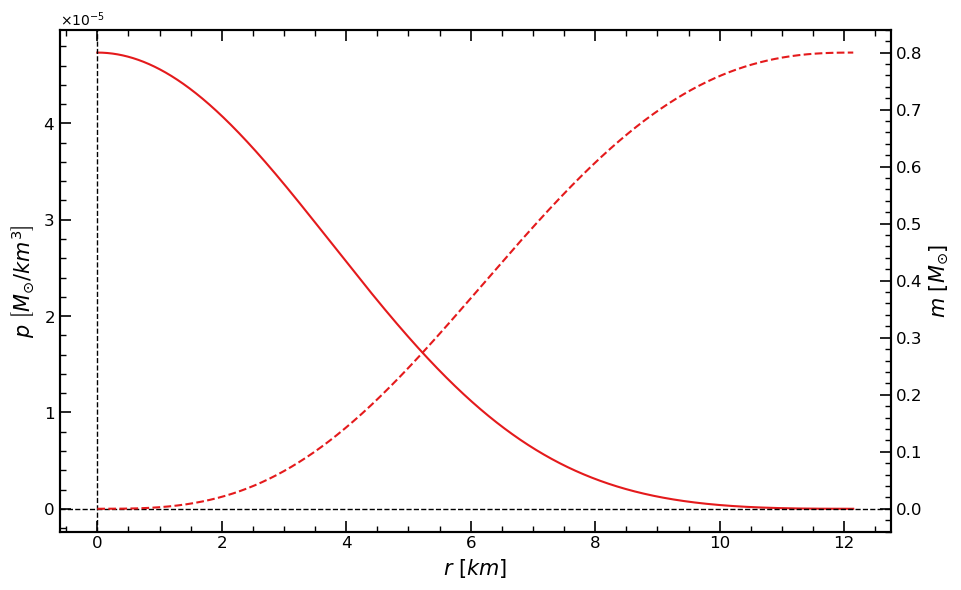

In [14]:
###############################################################################
# Define the functions
###############################################################################
def eos (p, dm_m=0.939565):
    """
    Given a pressure p, gives the value of density rho in acordance to the EoS.

    Parameters
    ----------
    p : float
        Pressure.
    dm_m : float
        Mass of the particle ing GeV.

    Returns
    -------
    TYPE
        Density(p).

    """
    if p <= 0:
        return 0
    
    Gamma = 5/3
    K = ((dm_m)**(-8/3))*8.0164772576254
    rho = (p / K) ** (1/Gamma)
        
    return rho

def system_of_ODE (r, y):
    """
    Function that calculates the derivatives of m and the pressure. This function is used for the runge-Kutta method.

    Parameters
    ----------
    r : float
        radius inside of the star.
    y : tuple
        (m, p), where m is the mass, p is the preassure of the fluid, evaluated at point r. 
    
    Returns
    -------
    dm_dr : float
        rate of change of the mass.
    dp_dr : float
        rate of change of the pressure of fluid.

    """
    m, p = y
    rho = eos(p)
    
    dm_dr = 4 * np.pi * (rho) * r**2
    dphi_dr = (G * m + 4 * np.pi * G * r**3 * (p)) / (r * (r - 2 * G * m))
    dp_dr = -(rho + p) * dphi_dr
    
    return (dm_dr, dp_dr)
    
def RK4O_with_stop (y0, r_range, h):
    """
    Function that integrates the y vector using a Runge-Kutta 4th orther method.
    Due to the physics of our problem. The function is built with a condition that doesn't allow negative pressures. 

    Parameters
    ----------
    y0 : tuple
        Starting conditions for our variables: (m_0, p_c)
    r_range : tuple
        Range of integratio: (r_0, r_max)
    h : float
        Step size of integration.
        
    Returns
    -------
    r_values : array
        Array containing the different values of r.
        
    y_values : array
        Array containig the solutions for the vector y: (m_values, p_values).
    """
    
    r_start, r_end = r_range
    r_values = [r_start]
    y_values = [y0]
    
    r = r_start
    y = np.array(y0)

    while r <= r_end:
        k1 = h * np.array(system_of_ODE(r, y))
        k2 = h * np.array(system_of_ODE(r + h / 2, y + k1 / 2))
        k3 = h * np.array(system_of_ODE(r + h / 2, y + k2 / 2))
        k4 = h * np.array(system_of_ODE(r + h, y + k3))

        y_next = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6

        # Stopping conditions: p<p_c*1e-10
        if y_next[1] <= y0[1]*1e-10: # If both pressures drop to 0 then the star stops there.
            break
        
        r += h
        r_values.append(r)
        y_values.append(y_next)
        y = y_next
        
    return (np.array(r_values), np.array(y_values))

def TOV_solver (y0, r_range, h):
    """
    Using a 4th Runge Kutta method, it solves the TOV for a perfect fluid star.
    It guives the mass and preassure values in all of the stars radius.

    Parameters
    ----------
    y0 : tuple
        Starting conditions for our variables: (m_0, p_c).
    r_range : tuple
        Range of integratio: (r_0, r_max).
    h : float
        Step size of integration.

    Returns
    -------
    r_values : array
        Array containing the different values of r.
    m_values : array
        Array containing the different values of m(r).
    p_values : array
        Array containing the different values of p(r).
    """
    
    r_values, y_values = RK4O_with_stop(y0, r_range, h)
    
    m_values = y_values[:, 0]
    p_values = y_values[:, 1]
    
    return (r_values, m_values, p_values)

def find_pc (M_target):
    """
    Finds the value of central pressure that creates a star of mass M_target.

    Parameters
    ----------
    M_target : float
        Desired mass.
    eos_type : int
        Type of EoS to use. 0 for an EoS of constant density. 1 for a Polytropic EoS.

    Raises
    ------
    ValueError
        When the root finding algorithm does not converge.

    Returns
    -------
    float
        value of pc that creates a star of mass M_target.
    """
    def f(pc):
        r, m, p = TOV_solver((0, pc), (1e-6, 100), 1e-3)
        M = m[-1]
        return (M - M_target) / M_target
    
    pc_guess = M_target*0.5e-5
    result = opt.root_scalar(f, x0=pc_guess, method='secant', x1=pc_guess*1.1)
    if result.converged:
        return result.root
    else:
        raise ValueError("Root-finding did not converge")
      
def solve_single_star_MR_curve(args):
    pc, r_range, h = args
    r_i, m_i, p_0 = TOV_solver([0, pc], r_range, h)
    
    R_i = r_i[-1]
    M_i = m_i[-1]
    
    return R_i, M_i

def MR_curve(pc_range, r_range, h, n):
    """
    Computes the mass-radius (M-R) curve for a compact star by solving the 
    Tolman-Oppenheimer-Volkoff (TOV) equations over a range of central pressures.
    Parallelized using multiprocessing.

    Parameters
    ----------
    pc_range : tuple
        Tuple (pc_start, pc_end) specifying the range of central pressures.
    r_range : tuple
        Range of integratio: (r_0, r_max).
    h : float
        Step size used in the numerical integration.
    n : int
        Number of points to sample between pc_start and pc_end (logarithmically spaced).

    Returns
    -------
    R_values : np.ndarray
        Array of stellar radii corresponding to each central pressure.
    M_values : np.ndarray
        Array of stellar masses corresponding to each central pressure.
    """
    pc_start, pc_end = pc_range
    pc_list = np.geomspace(pc_start, pc_end, n)
    args_list = [(pc, r_range, h) for pc in pc_list]
    
    with mp.Pool(mp.cpu_count()) as pool:
        results = list(tqdm(pool.imap(solve_single_star_MR_curve, args_list), total=n, desc="Processing Stars"))
        
    R_values, M_values = zip(*results)
    return np.array(R_values), np.array(M_values)

if __name__ == '__main__':

###############################################################################
# Calculate the data
###############################################################################

    M = 0.8
    pc = find_pc(M)
    r, m, p = TOV_solver((0, pc), (1e-6, 100), 1e-3)

###############################################################################
# Plot the data
###############################################################################
    
    fig, ax1 = plt.subplots(figsize=(9.71, 6))
    colors = sns.color_palette("Set1", 10)
    
    # Plot p
    ax1.plot(r, p, label=r'$p(r)$', color = colors[0], linewidth=1.5, linestyle='-')
    ax1.set_xlabel(r'$r$ $\left[km\right]$', fontsize=15, loc='center')
    ax1.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center', color='k')
    ax1.tick_params(axis='y', colors='k')
    ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
    
    # Plot m
    ax2 = ax1.twinx()
    ax2.plot(r, m, label=r'$m(r)$', color = colors[0], linewidth=1.5, linestyle='--')
    ax2.set_ylabel(r'$m$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center', color='k')
    ax2.tick_params(axis='y', colors='k')
    
    # Add axis lines
    ax1.axhline(0, color='k', linewidth=1.0, linestyle='--')
    ax1.axvline(0, color='k', linewidth=1.0, linestyle='--')
    
    # Configure ticks
    ax1.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True)
    ax1.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True)
    ax1.minorticks_on()
    ax2.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
    ax2.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
    ax2.minorticks_on()
    
    # Set thicker axes
    for ax in [ax1, ax2]:
        ax.spines['top'].set_linewidth(1.5)
        ax.spines['right'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_color('k')
        ax.spines['right'].set_color('k')
        ax.spines['bottom'].set_color('k')
        ax.spines['left'].set_color('k')
        
    # Set limits
    if False == True:
        ax1.set_xlim(0, 11.8)
        ax1.set_ylim(0, 1.5e-3)
        ax2.set_ylim(0, 4.2)
        
    # Configure ticks spacing
    if False == True:
        ax1.set_xticks(np.arange(0, 12, 2))
        #ax1.set_xticks(np.arange(0, 9.6, 0.2), minor=True)
        ax1.set_yticks(np.arange(0, 1.51e-3, 0.2e-3))
        #ax1.set_yticks(np.arange(0, 8.1e-5, 0.2e-5), minor=True)
        ax2.set_yticks(np.arange(0, 4.21, 0.5))
        #ax2.set_yticks(np.arange(0, 1.01, 0.02), minor=True)
        
    handles_list = [
        mlines.Line2D([], [], color=colors[0], linestyle='-', linewidth=1.5, label=r"$p(r)$"),
        mlines.Line2D([], [], color=colors[0], linestyle='--', linewidth=1.5, label=r"$m(r)$"),
        ]
        
    #plt.legend(handles=handles_list, fontsize=15, loc = "upper right", bbox_to_anchor=(0.99, 0.99), frameon=True, fancybox=False,
               #ncol = 2,edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)
        
    plt.tight_layout()
    plt.savefig(rf"figures\poly_TOV.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Estrellas de Neutrones

### EoS

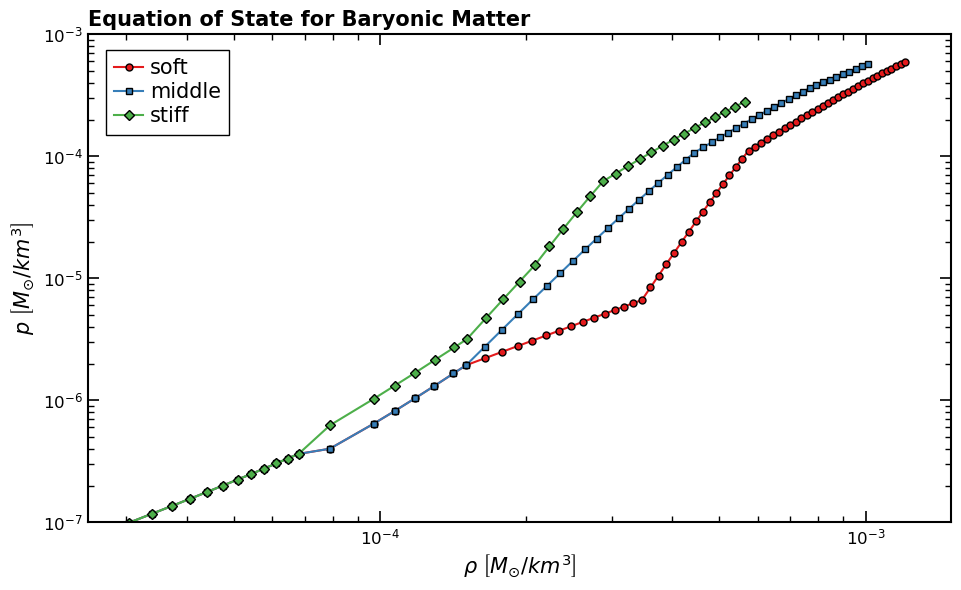

In [42]:
data = {}

eos_list = ['soft', 'middle', 'stiff']
for eos in eos_list:
    eos_data = pd.read_excel(f"data_eos\eos_{eos}.xlsx")
    data[f"{eos}"] = eos_data

fig, ax = plt.subplots(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)
eos_colors = {"soft": 0, "middle": 1, "stiff": 2}
eos_markers = {"soft": "o", "middle": "s", "stiff": "D"}

for eos in eos_list:
    ax.plot(data[f"{eos}"]["Density"], data[f"{eos}"]["Pressure"], 
            label=f"{eos}", color=colors[eos_colors[f"{eos}"]], linewidth=1.5, linestyle='-',
           marker = eos_markers[f'{eos}'],  mfc=colors[eos_colors[f"{eos}"]], mec = 'k', ms = 5)

plt.title(r'Equation of State for Baryonic Matter', fontsize=15, loc='left', fontweight='bold')
ax.set_xlabel(r'$\rho$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center')
ax.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center')
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
ax.set_xscale('log')
ax.set_yscale('log')

ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right = True)
ax.minorticks_on()

ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_color('k')
ax.spines['right'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

ax.set_xlim(2.5e-5, 1.5e-3)
ax.set_ylim(1e-7, 1e-3)

plt.legend(fontsize=15, loc = "upper left", bbox_to_anchor=(0.009, 0.99), frameon=True, fancybox=False, ncol = 1,
           edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

plt.tight_layout()
plt.savefig(f"figures\EoS_NS_High.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Estudio de la rigidez

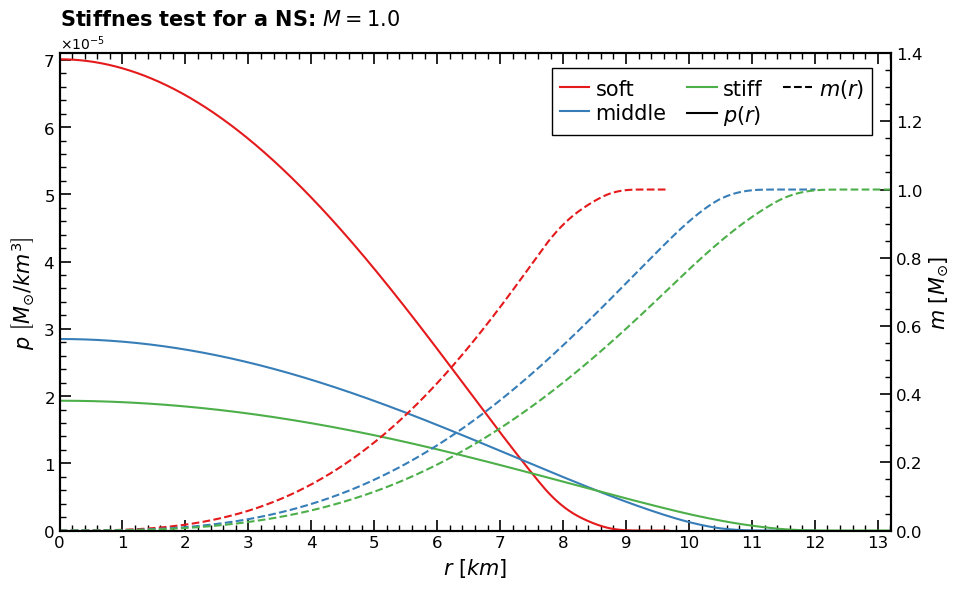

In [11]:
data = {}

s_type = 1
d_type = 0
EsOS = ['soft', 'middle', 'stiff']
p1_c = 'M'
p1_v = 1.0

for eos_c in EsOS:
    df = pd.read_csv(f"data\{s_type}_{d_type}_{eos_c}_{p1_c}_{p1_v}.csv")
    data[f'{eos_c}'] = df

# Configure the plot
fig, ax1 = plt.subplots(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)
eos_colors = {"soft": 0, "middle": 1, "stiff": 2}

# Plot the pressure
for eos_c in EsOS:
    c = eos_colors[eos_c]
    ax1.plot(data[f'{eos_c}']['r'], data[f'{eos_c}']['p_A'], label=rf'$p_{{{eos_c}}}(r)$', color = colors[c], linewidth=1.5, linestyle='-')
ax1.set_xlabel(r'$r$ $\left[km\right]$', fontsize=15, loc='center')
ax1.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center', color='k')
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))

# Plot the mass
ax2 = ax1.twinx()
for eos_c in EsOS:
    c = eos_colors[eos_c]
    ax2.plot(data[f'{eos_c}']['r'], data[f'{eos_c}']['m'], label=rf'$m_{{{eos_c}}}(r)$', color = colors[c], linewidth=1.5, linestyle='--')
ax2.set_ylabel(r'$m$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center', color='k')

# Set limits
if True == True:
    ax1.set_xlim(0, 13.21)
    ax1.set_ylim(0, 7.1e-5)
    ax2.set_ylim(0, 1.4)

# Configure ticks
ax1.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True)
ax1.minorticks_on()
ax2.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
ax2.minorticks_on()

# Configure ticks spacing
if True == True:
    ax1.set_xticks(np.arange(0, 13.21, 1))
    #ax1.set_xticks(np.arange(0, 9.6, 0.2), minor=True)
    ax1.set_yticks(np.arange(0, 7.1e-5, 1e-5))
    #ax1.set_yticks(np.arange(0, 1.31e-4, 0.025e-4), minor=True)
    ax2.set_yticks(np.arange(0, 1.41, 0.2))
    #ax2.set_yticks(np.arange(0, 1.01, 0.02), minor=True)

# Set thicker axes
for ax in [ax1, ax2]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
# Add a legend
Handles_list = [mlines.Line2D([], [], color=colors[0], linestyle='-', label=r"soft"),
mlines.Line2D([], [], color=colors[1], linestyle='-', label=r"middle"),
mlines.Line2D([], [], color=colors[2], linestyle='-', label=r"stiff"),
mlines.Line2D([], [], color='k', linestyle='-', label=r"$p(r)$"),
mlines.Line2D([], [], color='k', linestyle='--', label=r"$m(r)$")]
ax1.legend(handles=Handles_list, loc = "upper right", bbox_to_anchor=(0.99, 0.99), fontsize=15, frameon=True, fancybox=False, ncol = 3, edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)


# Save Fig as pdf
plt.title(rf'Stiffnes test for a NS: $M={p1_v}$', loc='left', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f"figures\stiffness_test_NS_{p1_c}_{p1_v}.pdf", format="pdf", bbox_inches="tight")

plt.show()

Este gráfico muestra cómo la rigidez de la Ecuación de Estado de una estrella afecta a su estructura. Como vemos, todas las estrellas tienen la misma cantidad de materia, pero sus radios son diferentes. Si la Ecuación de Estado es blanda, el radio es menor. Esto se debe a que una EoS blanda permite que la materia sea más compacta, lo que reduce el radio y aumenta la presión central. En cambio, una EoS rígida reparte la materia en un radio mayor y tiene una presión menor. 

Esto significa que la rigidez de una EoS nos indica la fuerza a la que puede comprimirse la materia. Cuanto más dura es una estrella, más difícil es compactarla.

### Curvas de Masa-Radio

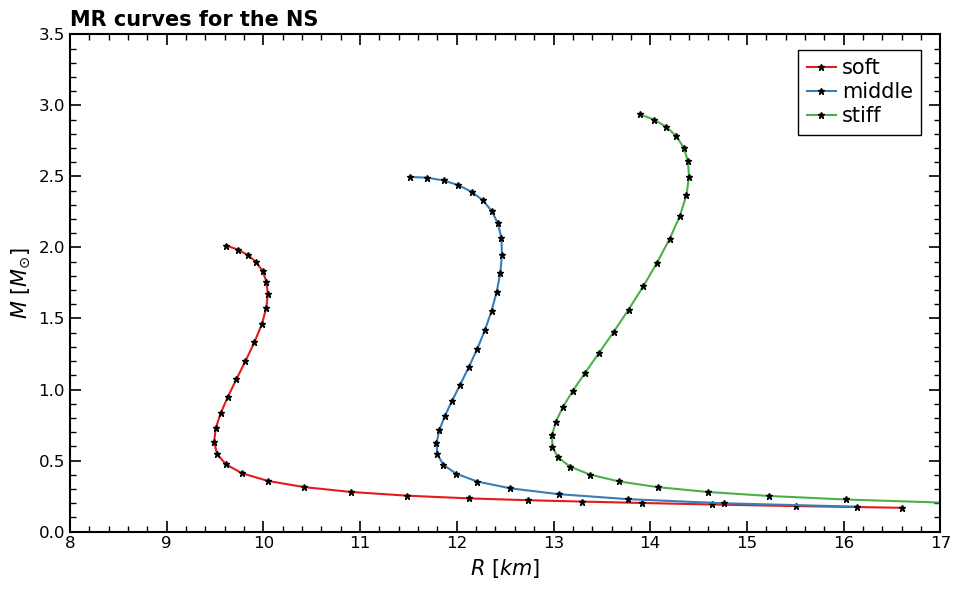

In [13]:
data = {}

s_type = 1
d_type = 1
EsOS = ['soft', 'middle', 'stiff']

for eos_c in EsOS:
    df = pd.read_csv(f"data\{s_type}_{d_type}_{eos_c}.csv")
    data[f"{eos_c}"] = df
    
# PLOT THE DATA
# Configure the plot
plt.figure(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)
eos_colors = {"soft": 0, "middle": 1, "stiff": 2}

for eos_c in EsOS:
    c = eos_colors[eos_c]
    plt.plot(data[f"{eos_c}"]["R"], data[f"{eos_c}"]["M"], label = rf'{eos_c}', color = colors[c], linewidth = 1.5, linestyle = '-', marker = "*",  mfc='k', mec = 'k', ms = 5)

# Add labels and title
plt.title(r'MR curves for the NS', loc='left', fontsize=15, fontweight='bold')
plt.xlabel(r'$R$ $\left[km\right]$', fontsize=15, loc='center')
plt.ylabel(r'$M$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center')

# Set limits
plt.xlim(8, 17)
plt.ylim(0, 3.5)

# Configure ticks for all four sides
plt.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
plt.minorticks_on()

# Customize tick spacing 
plt.gca().set_xticks(np.arange(8, 17.1, 1))  # Major x ticks 
plt.gca().set_yticks(np.arange(0, 3.51, 0.5))  # Major y ticks 

# Set thicker axes
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

# Add a legend
plt.legend(fontsize=15, loc = "upper right", bbox_to_anchor=(0.99, 0.99), frameon=True, fancybox=False, ncol = 1, edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

# Save plot as PDF
plt.tight_layout()
plt.savefig("figures\MR_curves_NS.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Estrellas de Materia Oscura

### EoS

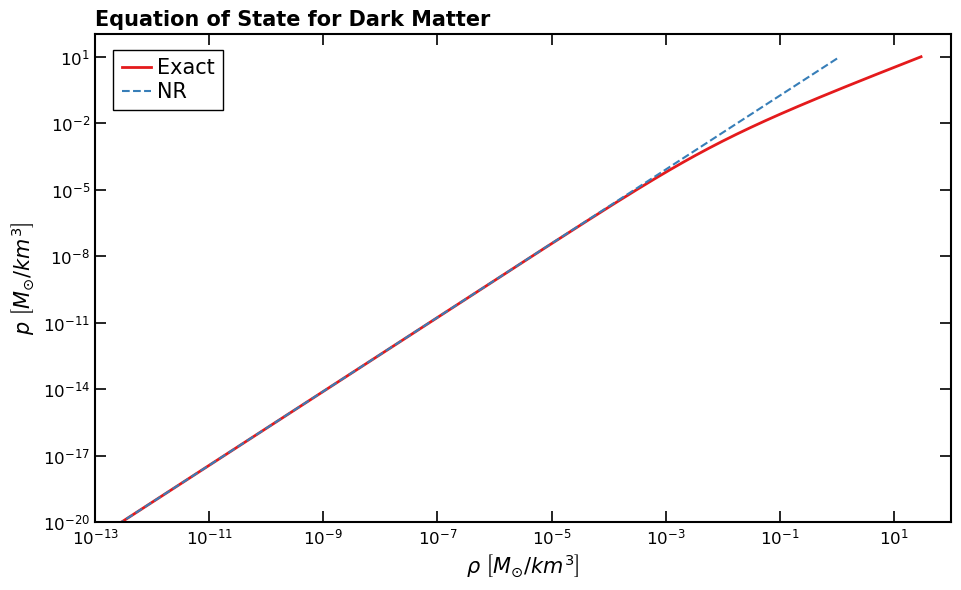

In [6]:
dm_m = 1.0

r_eos = pd.read_excel(f"data_eos\eos_cdifg_{dm_m}.xlsx")

def NR_eos (p):
    Gamma = 5/3
    K = ((dm_m)**(-8/3))*8.0165485819726
    rho = (p / K) ** (1/Gamma)
    return rho

rho_NR = []
for P in r_eos['P']:
    rho = NR_eos(P)
    rho_NR.append(rho)

fig, ax = plt.subplots(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)

plt.title(r'Equation of State for Dark Matter', fontsize=15, loc='left', fontweight='bold')
ax.set_xlabel(r'$\rho$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center')
ax.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center')
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(r_eos['rho'], r_eos['P'], 
            label="Exact", color=colors[0], linewidth=2, linestyle='-')
ax.plot(rho_NR, r_eos['P'], 
            label="NR", color=colors[1], linewidth=1.5, linestyle='--')

ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right = True)
ax.minorticks_on()

ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_color('k')
ax.spines['right'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

ax.set_xlim(1e-13, 1e2)
ax.set_ylim(1e-20, 1e2)

plt.legend(fontsize=15, loc = "upper left", bbox_to_anchor=(0.009, 0.99), frameon=True, fancybox=False, ncol = 1,
           edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

plt.tight_layout()
plt.savefig(f"figures\EoS_DM.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Efectos Relativistas

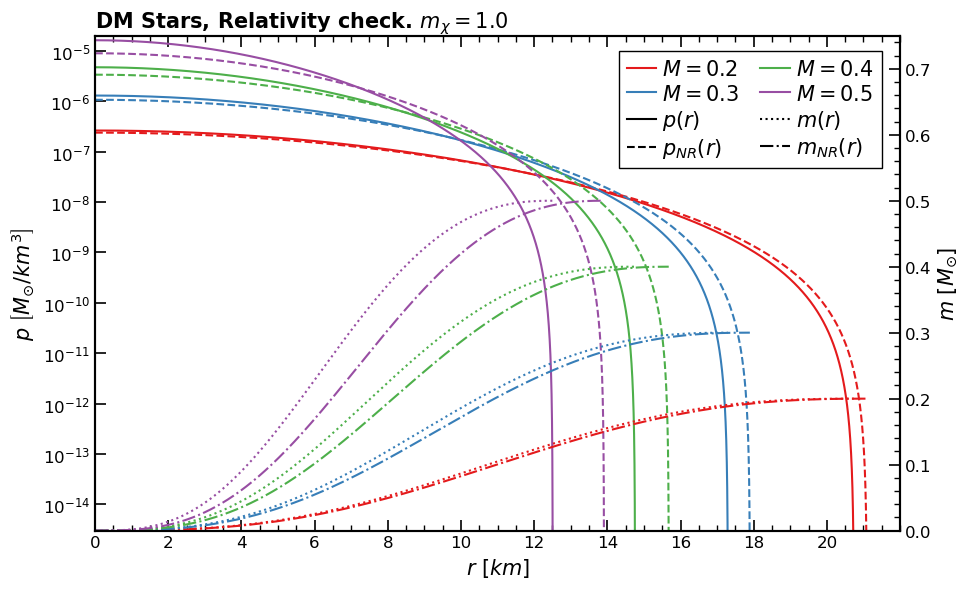

In [3]:
data = {}

s_type = 2
d_type = 0
eos_c = 'soft'
dm_m = 1.0
p1_c = 'M'
p1_v_list = [0.2, 0.3, 0.4, 0.5]

for p1_v in p1_v_list:
    df = pd.read_csv(f"data\{s_type}_{d_type}_{dm_m}_{p1_c}_{p1_v}.csv")
    df_NR = pd.read_csv(f"data\{s_type}_{d_type}_{dm_m}_{p1_c}_{p1_v}_NR.csv")
    data[f'{p1_v}'] = df
    data[f'{p1_v}_NR'] = df_NR

# Configure the plot
fig, ax1 = plt.subplots(figsize=(9.8, 6))
colors = sns.color_palette("Set1", 10)
c=0

# Set the axis.
ax1.set_xlabel(r'$r$ $\left[km\right]$', fontsize=15, loc='center')
ax1.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center', color='k')
ax1.tick_params(axis='y', colors='k')
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.set_ylabel(r'$m$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center', color='k')
ax2.tick_params(axis='y', colors='k')

# The plot thickenss
for p1_v in p1_v_list:
    ax1.plot(data[f"{p1_v}"]['r'], data[f"{p1_v}"]['p_B'], color = colors[c], linewidth=1.5, linestyle='-')
    ax2.plot(data[f"{p1_v}"]['r'], data[f"{p1_v}"]['m'], color = colors[c], linewidth=1.5, linestyle=':')
    ax1.plot(data[f"{p1_v}_NR"]['r'], data[f"{p1_v}_NR"]['p_B'], color = colors[c], linewidth=1.5, linestyle='--')
    ax2.plot(data[f"{p1_v}_NR"]['r'], data[f"{p1_v}_NR"]['m'], color = colors[c], linewidth=1.5, linestyle='-.')
    c+=1

if True == True:
    ax1.set_xlim(0, 22)
    ax1.set_ylim(3e-15, 2e-5)
    ax2.set_ylim(0, 0.75)

ax1.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True)
ax1.minorticks_on()
ax2.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
ax2.minorticks_on()

if True == True:
    ax1.set_xticks(np.arange(0, 22, 2))
    #ax1.set_xticks(np.arange(0, 9.6, 0.2), minor=True)
    ax1.set_yticks(np.geomspace(1e-14, 1e-5, 10))
    #ax1.set_yticks(np.arange(0, 8.1e-5, 0.2e-5), minor=True)
    ax2.set_yticks(np.arange(0, 0.75, 0.1))
    ax2.set_yticks(np.arange(0, 0.75, 0.02), minor=True)
    
for ax in [ax1, ax2]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')

    
handles_list = [
    mlines.Line2D([], [], color=colors[0], linestyle='-', label=r"$M=0.2$"),
    mlines.Line2D([], [], color=colors[1], linestyle='-', label=r"$M=0.3$"),
    mlines.Line2D([], [], color='k', linestyle='-', label=r"$p(r)$"),
    mlines.Line2D([], [], color='k', linestyle='--', label=r"$p_{{NR}}(r)$"),
    mlines.Line2D([], [], color=colors[2], linestyle='-', label=r"$M=0.4$"),
    mlines.Line2D([], [], color=colors[3], linestyle='-', label=r"$M=0.5$"),
    mlines.Line2D([], [], color='k', linestyle=':', label=r"$m(r)$"),
    mlines.Line2D([], [], color='k', linestyle='-.', label=r"$m_{{NR}}(r)$")]

plt.legend(handles=handles_list, loc = "upper right", bbox_to_anchor=(0.99, 0.99), fontsize=15, frameon=True, fancybox=False, ncol = 2, edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

# Save plot as PDF
plt.title(rf'DM Stars, Relativity check. $m_{{\chi}} = {dm_m}$', loc='left', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f"figures\{s_type}_relativity_check_{dm_m}.pdf", format="pdf", bbox_inches="tight")

plt.show()

En este gárfico podemos ver la diferencia que tiene considerar una EoS relativistas en la estructura de la estrella. Podemos ver que el caso no relativista (NR) en todos los casos es más rígido que el caso real. Esto se debe a que en el núcleo, donde las densidades y presiones tienen que ser relativistas, el caso NR nos dice que la presión es más fuerte de lo que es en realidad. Este aumento de presión en el caso NR hace que la materia sea más dificil de compactar haciendo que la EoS sea más rígida y el radio sea mayor.

## Estrellas de Neutrones con Materia Oscura (DANS)

### Efectos de añadir DM a una NS.

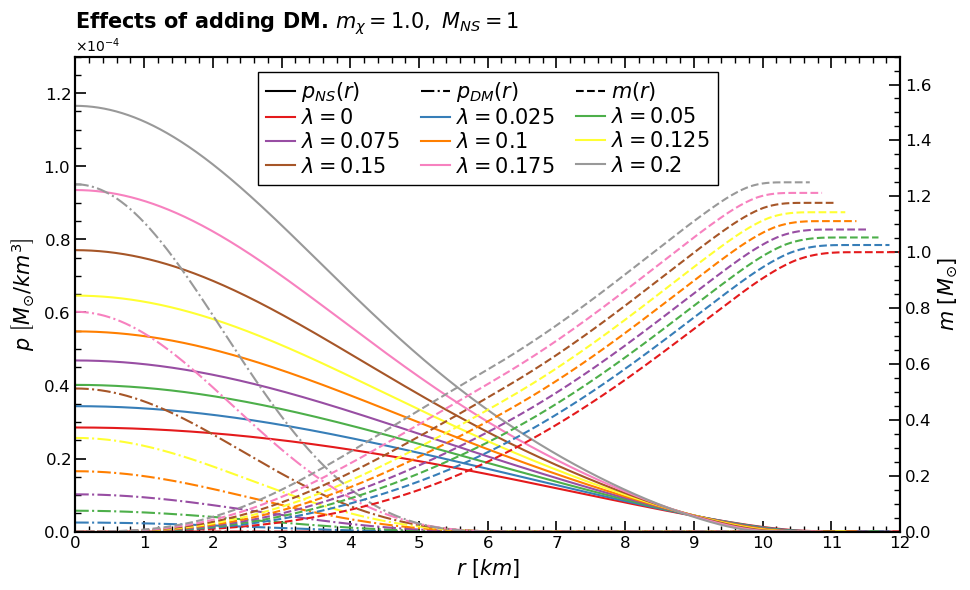

In [55]:
s_type = 3
d_type = 0
eos_c = 'middle'
dm_m = 1.0
p1_c = 'M'
p2_c = 'l'
p2_v_list = [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
p_dic = {}
data = {}
for p2_v in p2_v_list:
    p1_v = round(1/(1-p2_v), 4)
    p_dic[f'{p2_v}'] = p1_v
    df = pd.read_csv(f"data\{s_type}_{d_type}_{eos_c}_{dm_m}_{p1_c}_{p1_v}_{p2_c}_{p2_v}.csv")
    data[f'{p2_v}'] = df

# Configure the plot
fig, ax1 = plt.subplots(figsize=(9.8, 6))
colors = sns.color_palette("Set1", 10)
c=0

# Set the axis.
ax1.set_xlabel(r'$r$ $\left[km\right]$', fontsize=15, loc='center')
ax1.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center', color='k')
ax1.tick_params(axis='y', colors='k')
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
#ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.set_ylabel(r'$m$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center', color='k')
ax2.tick_params(axis='y', colors='k')

# The plot thickenss
for p2_v in p2_v_list:
    ax1.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['p_A'], color = colors[c], linewidth=1.5, linestyle='-')
    ax2.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['m'], color = colors[c], linewidth=1.5, linestyle='--')
    ax1.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['p_B'], color = colors[c], linewidth=1.5, linestyle='-.')
    c+=1

ax1.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True)
ax1.minorticks_on()
ax2.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
ax2.minorticks_on()

for ax in [ax1, ax2]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')

if True == True:
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 1.3e-4)
    ax2.set_ylim(0, 1.7)

if True == True:
    ax1.set_xticks(np.arange(0, 12.01, 1))
    #ax1.set_xticks(np.arange(0, 12.01, 0.2), minor=True)
    ax1.set_yticks(np.arange(0, 1.301e-4, 0.2e-4))
    #ax1.set_yticks(np.arange(0, 1.201e-4, 0.05e-4), minor=True)
    ax2.set_yticks(np.arange(0, 1.71, 0.2))
    #ax2.set_yticks(np.arange(0, 0.75, 0.02), minor=True)

handles_list = [
    mlines.Line2D([], [], color='k', linestyle='-', label=r"$p_{NS}(r)$"),
    mlines.Line2D([], [], color=colors[0], linestyle='-', label=r"$\lambda = 0$"),
    mlines.Line2D([], [], color=colors[3], linestyle='-', label=r"$\lambda = 0.075$"),
    mlines.Line2D([], [], color=colors[6], linestyle='-', label=r"$\lambda = 0.15$"),
    mlines.Line2D([], [], color='k', linestyle='-.', label=r"$p_{DM}(r)$"),
    mlines.Line2D([], [], color=colors[1], linestyle='-', label=r"$\lambda = 0.025$"),
    mlines.Line2D([], [], color=colors[4], linestyle='-', label=r"$\lambda = 0.1$"),
    mlines.Line2D([], [], color=colors[7], linestyle='-', label=r"$\lambda = 0.175$"),
    mlines.Line2D([], [], color='k', linestyle='--', label=r"$m(r)$"),
    mlines.Line2D([], [], color=colors[2], linestyle='-', label=r"$\lambda = 0.05$"),
    mlines.Line2D([], [], color=colors[5], linestyle='-', label=r"$\lambda = 0.125$"),
    mlines.Line2D([], [], color=colors[8], linestyle='-', label=r"$\lambda = 0.2$")]

plt.legend(handles=handles_list, loc = "upper center", bbox_to_anchor=(0.5, 0.99), fontsize=15, frameon=True,
           fancybox=False, ncol = 3, edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

# Save plot as PDF
plt.title(rf'Effects of adding DM. $m_{{\chi}} = {dm_m},$ $M_{{NS}}=1$', loc='left', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f"figures\DM_add_NS_1_{eos_c}_{dm_m}.pdf", format="pdf", bbox_inches="tight")

plt.show()

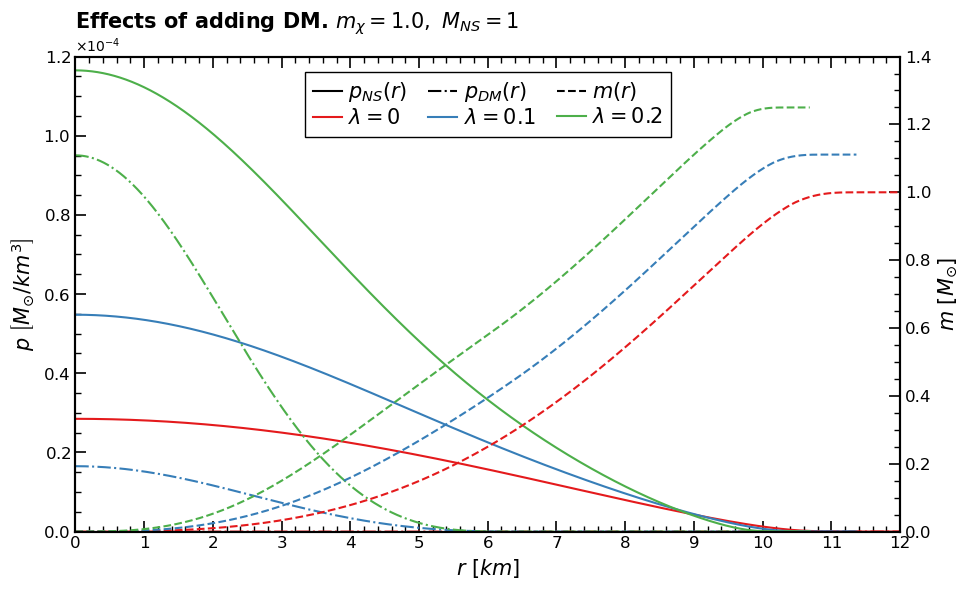

In [59]:
s_type = 3
d_type = 0
eos_c = 'middle'
dm_m = 1.0
p1_c = 'M'
p2_c = 'l'
p2_v_list = [0.0, 0.1, 0.2]
p_dic = {}
data = {}
for p2_v in p2_v_list:
    p1_v = round(1/(1-p2_v), 4)
    p_dic[f'{p2_v}'] = p1_v
    df = pd.read_csv(f"data\{s_type}_{d_type}_{eos_c}_{dm_m}_{p1_c}_{p1_v}_{p2_c}_{p2_v}.csv")
    data[f'{p2_v}'] = df

# Configure the plot
fig, ax1 = plt.subplots(figsize=(9.8, 6))
colors = sns.color_palette("Set1", 10)
c=0

# Set the axis.
ax1.set_xlabel(r'$r$ $\left[km\right]$', fontsize=15, loc='center')
ax1.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center', color='k')
ax1.tick_params(axis='y', colors='k')
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
#ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.set_ylabel(r'$m$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center', color='k')
ax2.tick_params(axis='y', colors='k')

# The plot thickenss
for p2_v in p2_v_list:
    ax1.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['p_A'], color = colors[c], linewidth=1.5, linestyle='-')
    ax2.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['m'], color = colors[c], linewidth=1.5, linestyle='--')
    ax1.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['p_B'], color = colors[c], linewidth=1.5, linestyle='-.')
    c+=1

ax1.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True)
ax1.minorticks_on()
ax2.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
ax2.minorticks_on()

for ax in [ax1, ax2]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')

if True == True:
    ax1.set_xlim(0, 12)
    ax1.set_ylim(0, 1.2e-4)
    ax2.set_ylim(0, 1.4)

if True == True:
    ax1.set_xticks(np.arange(0, 12.01, 1))
    #ax1.set_xticks(np.arange(0, 12.01, 0.2), minor=True)
    ax1.set_yticks(np.arange(0, 1.201e-4, 0.2e-4))
    #ax1.set_yticks(np.arange(0, 1.201e-4, 0.05e-4), minor=True)
    ax2.set_yticks(np.arange(0, 1.41, 0.2))
    #ax2.set_yticks(np.arange(0, 0.75, 0.02), minor=True)

handles_list = [
    mlines.Line2D([], [], color='k', linestyle='-', label=r"$p_{NS}(r)$"),
    mlines.Line2D([], [], color=colors[0], linestyle='-', label=r"$\lambda = 0$"),
    mlines.Line2D([], [], color='k', linestyle='-.', label=r"$p_{DM}(r)$"),
    mlines.Line2D([], [], color=colors[1], linestyle='-', label=r"$\lambda = 0.1$"),
    mlines.Line2D([], [], color='k', linestyle='--', label=r"$m(r)$"),
    mlines.Line2D([], [], color=colors[2], linestyle='-', label=r"$\lambda = 0.2$")]

plt.legend(handles=handles_list, loc = "upper center", bbox_to_anchor=(0.5, 0.99), fontsize=15, frameon=True,
           fancybox=False, ncol = 3, edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

# Save plot as PDF
plt.title(rf'Effects of adding DM. $m_{{\chi}} = {dm_m},$ $M_{{NS}}=1$', loc='left', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f"figures\DM_add_NS_1_{eos_c}_{dm_m}_reduced.pdf", format="pdf", bbox_inches="tight")

plt.show()

En esta gráfica podemos ver el efecto que tiene añadir diferentes cantidades de materia oscura a una estrella de neutrones de 1 $M_{\odot}$. En ellas se usa el parámetro $\lambda = \frac{M_{DM}}{M_\odot}$. A medida que añadimos materia oscura, el radio total de la estrella disminuye al igual que la presión central del fluido aumenta. Esta gráfica nos permite ver que aunque los dos fluidos no tengan ninguna interacción entre si, notan la gravedad del otro. Si añadimos materia oscura en forma de núcleo en la estrella, su materia se compacta devido a este aumento en la gravedad.

### Curvas de Masa-Radio

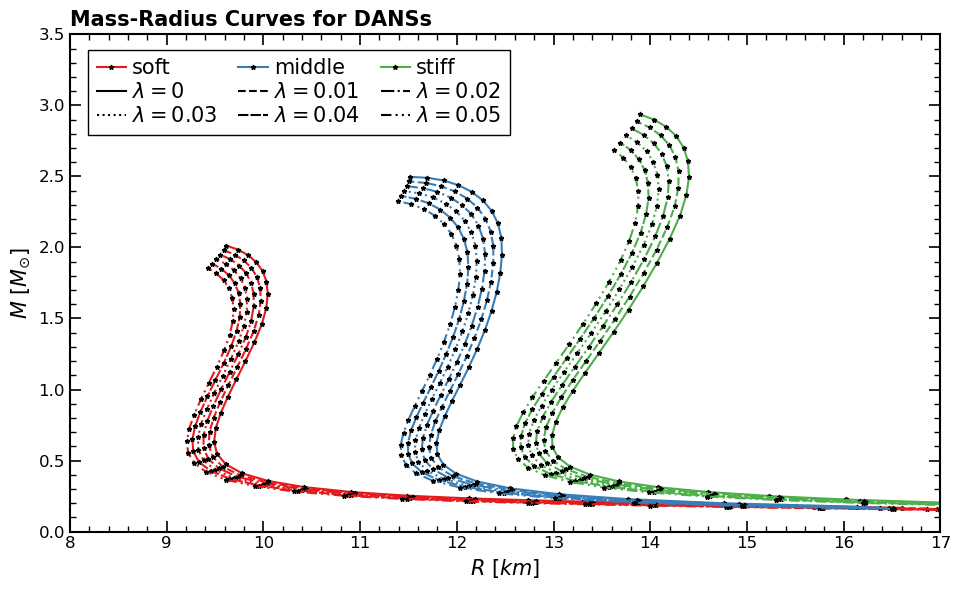

In [26]:
s_type = 3
d_type = 1
eos_c_list = ['soft','middle','stiff']
dm_m = 1.0
p2_c = 'l'
p2_v_list = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
data = {}

for eos_c in eos_c_list:
    for p2_v in p2_v_list:
        df = pd.read_csv(f"data\{s_type}_{d_type}_{eos_c}_{dm_m}_{p2_c}_{p2_v}.csv")
        data[f'{eos_c}_{p2_v}'] = df

fig, ax = plt.subplots(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)
eos_colors = {"soft": 0, "middle": 1, "stiff": 2}
styles = ['-', '--', '-.', ':', (0, (5, 1)), (0, (5, 2, 1, 2, 1, 2))]

for eos_c in eos_c_list:
    s=0
    for p2_v in p2_v_list:
        ax.plot(data[f"{eos_c}_{p2_v}"]["R"], data[f"{eos_c}_{p2_v}"]["M"], 
            color=colors[eos_colors[f"{eos_c}"]], linewidth=1.5, linestyle=styles[s],
           marker = '*',  mfc='k', mec = 'k', ms = 3.5)
        s+=1

plt.title(r'Mass-Radius Curves for DANSs', fontsize=15, loc='left', fontweight='bold')
ax.set_xlabel(r'$R$ $\left[ km \right]$', fontsize=15, loc='center')
ax.set_ylabel(r'$M$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center')

ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right = True)
ax.minorticks_on()

ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_color('k')
ax.spines['right'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

ax.set_xlim(8, 17)
ax.set_ylim(0, 3.5)

handles_list = [
    mlines.Line2D([], [], color=colors[0], linestyle='-', label=r"soft", marker = '*',  mfc='k', mec = 'k', ms = 3.5),
    mlines.Line2D([], [], color='k', linestyle='-', label=r"$\lambda = 0$"),
    mlines.Line2D([], [], color='k', linestyle=':', label=r"$\lambda = 0.03$"),
    mlines.Line2D([], [], color=colors[1], linestyle='-', label=r"middle", marker = '*',  mfc='k', mec = 'k', ms = 3.5),
    mlines.Line2D([], [], color='k', linestyle='--', label=r"$\lambda = 0.01$"),
    mlines.Line2D([], [], color='k', linestyle=(0, (5, 1)), label=r"$\lambda = 0.04$"),
    mlines.Line2D([], [], color=colors[2], linestyle='-', label=r"stiff", marker = '*',  mfc='k', mec = 'k', ms = 3.5),
    mlines.Line2D([], [], color='k', linestyle='-.', label=r"$\lambda = 0.02$"),
    mlines.Line2D([], [], color='k', linestyle=(0, (5, 2, 1, 2, 1, 2)), label=r"$\lambda = 0.05$")]

plt.legend(handles=handles_list, loc = "upper left", bbox_to_anchor=(0.009, 0.99), fontsize=15, frameon=True,
           fancybox=False, ncol = 3, edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

# Save plot as PDF
plt.tight_layout()
plt.savefig("figures\MR_curves_DANS.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Efectos de la masa de la materia oscura

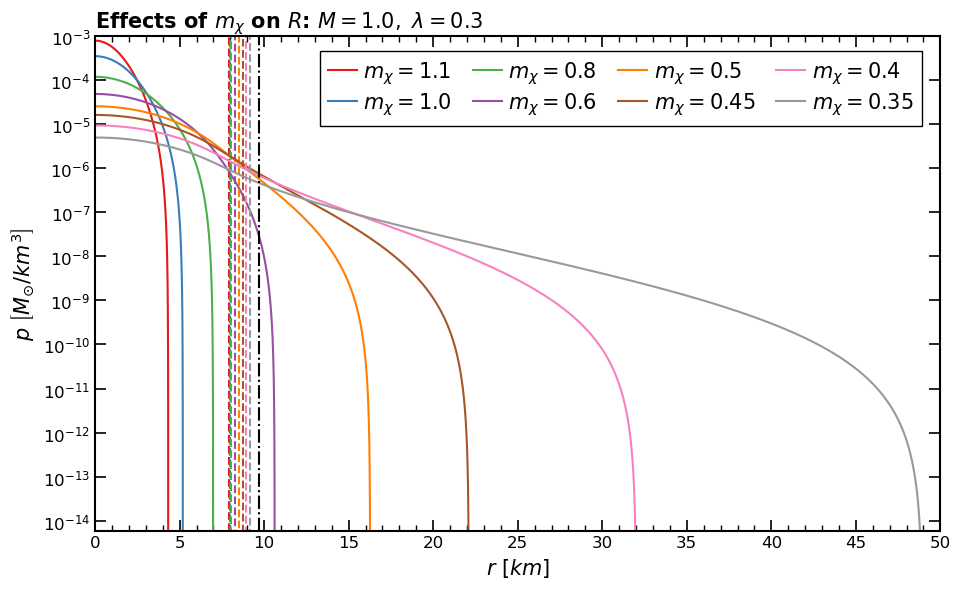

In [61]:
s_type = 3
d_type = 0
eos_c = 'soft'
dm_m_list = [1.1, 1.0, 0.8, 0.6, 0.5, 0.45, 0.4, 0.35]
p1_c = 'M'
p1_v = 1.0
p2_c = 'l'
p2_v = 0.3
data = {}

for dm_m in dm_m_list:
    df = pd.read_csv(f'data\{s_type}_{d_type}_{eos_c}_{dm_m}_{p1_c}_{p1_v}_{p2_c}_{p2_v}.csv')
    data[f'{dm_m}'] = df

fig, ax = plt.subplots(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)
c=0

for dm_m  in dm_m_list:
    if c == 5:
        c+=1
    ax.plot(data[f"{dm_m}"]["r"], data[f"{dm_m}"]["p_B"], 
            color=colors[c], linewidth=1.5, linestyle='-')
    ax.axvline(data[f"{dm_m}"]["R_A"][0], color = colors[c], linestyle=(c, [3.7, 1.6]))
    c+=1
ax.axvline(9.669001, color = 'k', linestyle='-.')

plt.title(rf'Effects of $m_{{\chi}}$ on $R$: $M={p1_v},$ $\lambda = {p2_v}$', fontsize=15, loc='left', fontweight='bold')
ax.set_xlabel(r'$r$ $\left[ km \right]$', fontsize=15, loc='center')
ax.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center')

ax.set_yscale('log')

ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right = True)
ax.minorticks_on()

ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_color('k')
ax.spines['right'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

ax.set_xlim(0, 50)
ax.set_ylim(6e-15, 1e-3)
ax.set_xticks(np.arange(0, 50.01, 5))
ax.set_yticks(np.geomspace(1e-14, 1e-3, 12))

handles_list = []
c=0
for dm_m in dm_m_list:
    if c == 5:
        c+=1
    handle = mlines.Line2D([], [], color=colors[c], linestyle='-', label=rf"$m_{{\chi}}={dm_m}$")
    c+=1
    handles_list.append(handle)

plt.legend(handles=handles_list, loc = "upper right", bbox_to_anchor=(0.99, 0.99), fontsize=15, frameon=True,
           fancybox=False, ncol = 4, edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

plt.tight_layout()
plt.savefig(f"figures\dm_mass_study_{eos_c}_{p1_v}_{p2_v}.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Cantidad máxima de DM en funión de la masa de la partícula.

#### Barrido de valores de $\alpha$

Con las DANS ocurre una cosa muy curiosa, y es que, como se muestra en la figura inferior, dada una DANS de masa $M$ fija, esta tiene un valor de $\lambda$ máximo que depende de la masa de la partícula de DM, $m_{\chi}$.

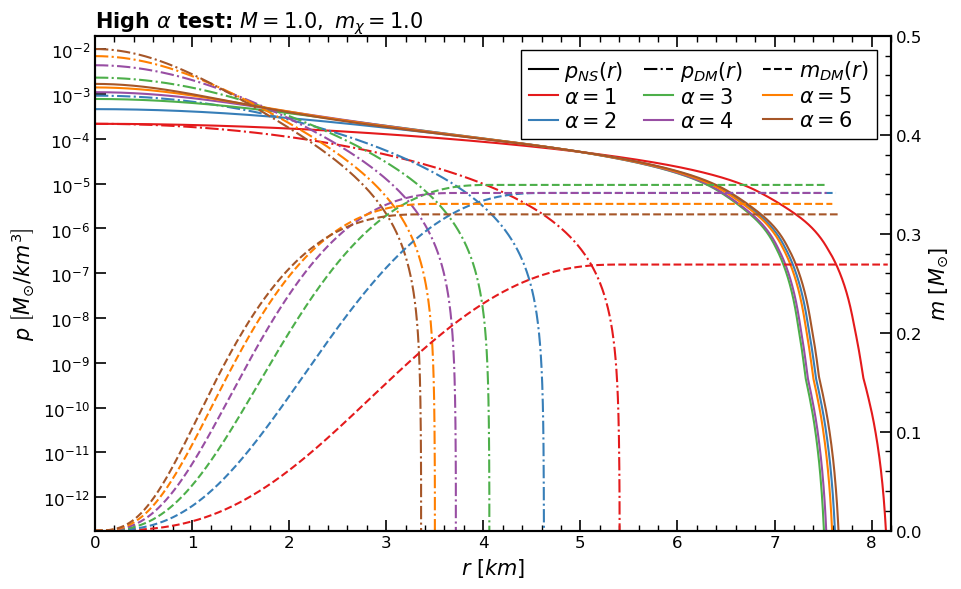

In [22]:
s_type = 3
d_type = 0
eos_c = 'soft'
dm_m = 1.0
p1_c = 'M'
p1_v = 1.0
p2_c = 'a'
p2_v_list = [1,2,3,4,5,6]
data = {}

for p2_v in p2_v_list:
    df = pd.read_csv(f'data\{s_type}_{d_type}_{eos_c}_{dm_m}_{p1_c}_{p1_v}_{p2_c}_{p2_v}.csv')
    data[f'{p2_v}'] = df

fig, ax1 = plt.subplots(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)
c=0

plt.title(rf'High $\alpha$ test: $M={p1_v},$ $m_{{\chi}} = {dm_m}$', fontsize=15, loc='left', fontweight='bold')
ax1.set_xlabel(r'$r$ $\left[km\right]$', fontsize=15, loc='center')
ax1.set_ylabel(r'$p$ $\left[ M_{\odot} / km^3 \right]$', fontsize=15, loc='center', color='k')
ax1.tick_params(axis='y', colors='k')
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3))
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.set_ylabel(r'$m$ $\left[ M_{\odot} \right]$', fontsize=15, loc='center', color='k')
ax2.tick_params(axis='y', colors='k')

for p2_v in p2_v_list:
    if c == 5:
        c+=1
    ax1.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['p_A'], label=rf'$\alpha = {p2_v}$', color = colors[c], linewidth=1.5, linestyle='-')
    ax1.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['p_B'], label=rf'$\alpha = {p2_v}$', color = colors[c], linewidth=1.5, linestyle='-.')
    ax2.plot(data[f'{p2_v}']['r'], data[f'{p2_v}']['m_B'], label=rf'$\alpha = {p2_v}$', color = colors[c], linewidth=1.5, linestyle='--')
    c+=1

ax1.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True)
ax1.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True)
ax1.minorticks_on()
ax2.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax2.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right=True)
ax2.minorticks_on()

for ax in [ax1, ax2]:
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_color('k')
    ax.spines['right'].set_color('k')
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')

ax1.set_xlim(0, 8.2)
ax1.set_ylim(1.8e-13, 2e-2)
ax2.set_ylim(0, 0.5)

ax1.set_xticks(np.arange(0, 8.2, 1))  
ax1.set_yticks(np.geomspace(1e-12, 1e-2, 11))
ax2.set_yticks(np.arange(0, 0.51, 0.1))

handles_list = [
    mlines.Line2D([], [], color='k', linestyle='-', label=r"$p_{NS}(r)$"),
    mlines.Line2D([], [], color=colors[0], linestyle='-', label=r"$\alpha = 1$"),
    mlines.Line2D([], [], color=colors[1], linestyle='-', label=r"$\alpha = 2$"),
    mlines.Line2D([], [], color='k', linestyle='-.', label=r"$p_{DM}(r)$"),
    mlines.Line2D([], [], color=colors[2], linestyle='-', label=r"$\alpha = 3$"),
    mlines.Line2D([], [], color=colors[3], linestyle='-', label=r"$\alpha = 4$"),
    mlines.Line2D([], [], color='k', linestyle='--', label=r"$m_{DM}(r)$"),
    mlines.Line2D([], [], color=colors[4], linestyle='-', label=r"$\alpha = 5$"),
    mlines.Line2D([], [], color=colors[6], linestyle='-', label=r"$\alpha = 6$")]

plt.legend(handles=handles_list, loc = "upper right", bbox_to_anchor=(0.995, 0.992), fontsize=15, frameon=True,
           fancybox=False, ncol = 3, edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

plt.tight_layout()
plt.savefig(f"figures\High_a_test_{eos_c}_{p1_v}_{dm_m}.pdf", format="pdf", bbox_inches="tight")

plt.show()

Vease que en el caso de $\alpha=2$ y $\alpha=4$, $\lambda$ es muy parecido. Esto es curioso ya que nos dice que tenemos dos configuraciones de materia oscura que dan la misma $\lambda$, una de ella es materia oscura compactada y la otra difusa. Además vemos que nuestra observación anterior de 'cuanto más compacta sea la componente de DM, menor será el radio' se confirma en este caso ya que $R(\alpha = 4) < R(\alpha = 2)$.

La forma en la que el programa encuentra el $\alpha$ que da un $\lambda$ deseado es tal que siempre encuentra el $\alpha$ menor. Debido a que normalmente estamos trabajando con valores pequeños de estas cantidades, las soluciones compactas serán valores de $\alpha$ demasiado grandes para ser soluciones físicas. Esto nos permite asegurar que los efectos de tener 2 valores de $\alpha$ para un único $\lambda$ es algo que solo se debe tener en cuenta para $\alpha \gtrsim 1$.

#### Cantidades máximas de materia oscura en función de la masa de materia oscura.

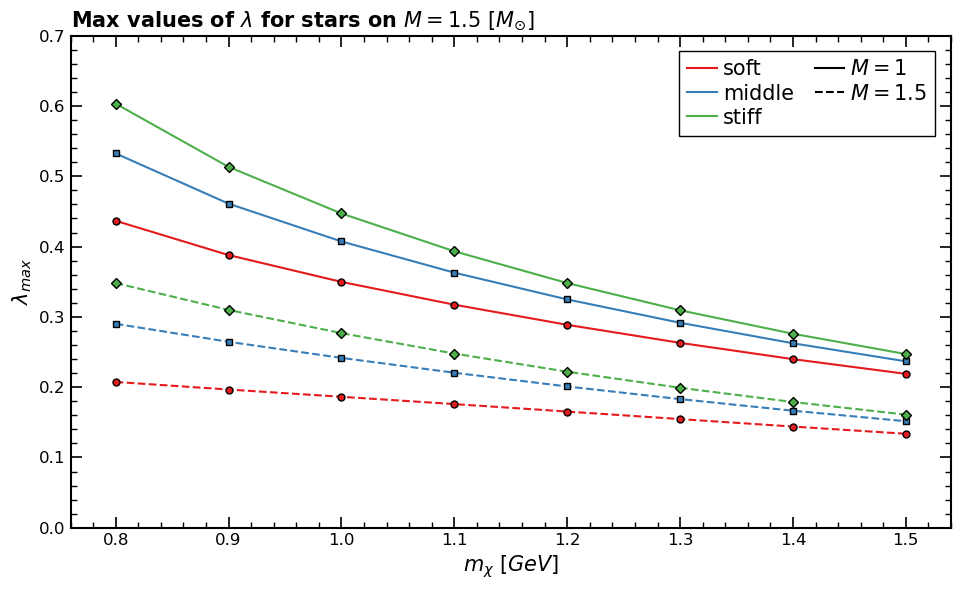

In [3]:
s_type = 3
d_type = 2
eos_c_list = ['soft', 'middle','stiff']
dm_m_list = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
p1_c = 'M'
p1_v_list = [1.0, 1.5]

a_values = {'1.0':{'soft':[], 'middle':[], 'stiff':[]}, '1.5':{'soft':[], 'middle':[], 'stiff':[]}}
l_values = {'1.0':{'soft':[], 'middle':[], 'stiff':[]}, '1.5':{'soft':[], 'middle':[], 'stiff':[]}}
data = {}

for p1_v in p1_v_list:
    for eos_c in eos_c_list:
        for dm_m in dm_m_list:
            df = pd.read_csv(f"data\{s_type}_{d_type}_{eos_c}_{dm_m}_{p1_c}_{p1_v}.csv")
            data[f'{p1_v}_{eos_c}_{dm_m}'] = df
            a_values[f'{p1_v}'][f'{eos_c}'].append(df['p_B'][0]/df['p_A'][0])
            l_values[f'{p1_v}'][f'{eos_c}'].append(df['m_B'].tail(1).values[0]/df['m'].tail(1).values[0])

fig, ax = plt.subplots(figsize=(9.71, 6))
colors = sns.color_palette("Set1", 10)
eos_colors = {"soft": 0, "middle": 1, "stiff": 2}
eos_markers = {"soft": "o", "middle": "s", "stiff": "D"}
p1_style = {"1.0":'-', "1.5":'--'}

for p1_v in p1_v_list:
    for eos in eos_c_list:
        ax.plot(dm_m_list, l_values[f'{p1_v}'][f'{eos}'], color=colors[eos_colors[f"{eos}"]], linewidth=1.5, linestyle=p1_style[f"{p1_v}"],
               marker = eos_markers[f'{eos}'],  mfc=colors[eos_colors[f"{eos}"]], mec = 'k', ms = 5)

plt.title(rf'Max values of $\lambda$ for stars on $M={p1_v}$ $[M_{{\odot}}]$', fontsize=15, loc='left', fontweight='bold')
ax.set_xlabel(r'$m_{\chi}$ $\left[ GeV \right]$', fontsize=15, loc='center')
ax.set_ylabel(r'$\lambda_{max}$', fontsize=15, loc='center')

ax.tick_params(axis='both', which='major', direction='in', length=8, width=1.2, labelsize=12, top=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=4, width=1, labelsize=12, top=True, right = True)
ax.minorticks_on()

ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['top'].set_color('k')
ax.spines['right'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

ax.set_xlim(0.8-0.04, 1.5+0.04)
ax.set_ylim(0, 0.7)

handles_list = [
    mlines.Line2D([], [], color=colors[0], linestyle='-', label=r"soft"),
    mlines.Line2D([], [], color=colors[1], linestyle='-', label=r"middle"),
    mlines.Line2D([], [], color=colors[2], linestyle='-', label=r"stiff"),
    mlines.Line2D([], [], color='k', linestyle='-', label=r"$M=1$"),
    mlines.Line2D([], [], color='k', linestyle='--', label=r"$M=1.5$"),
    ]

plt.legend(handles=handles_list, fontsize=15, loc = "upper right", bbox_to_anchor=(0.994, 0.99), frameon=True, fancybox=False,
           ncol = 2,edgecolor="black", framealpha=1, labelspacing=0.2, handletextpad=0.3, handlelength=1.4, columnspacing=1)

plt.tight_layout()
plt.savefig(rf"figures\values_of_l_max_{p1_v}.pdf", format="pdf", bbox_inches="tight")

plt.show()
